#Citation

@ARTICLE{Veeling2018-qh,
  title         = "Rotation Equivariant {CNNs} for Digital Pathology",
  author        = "Veeling, Bastiaan S and Linmans, Jasper and Winkens, Jim and
                   Cohen, Taco and Welling, Max",
  month         =  jun,
  year          =  2018,
  archivePrefix = "arXiv",
  primaryClass  = "cs.CV",
  eprint        = "1806.03962"
}

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import h5py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import gc
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import Activation


In [4]:
#file path
file_path_x = '/content/drive/My Drive/patch/camelyonpatch_level_2_split_train_x.h5'
file_path_y = '/content/drive/My Drive/patch/camelyonpatch_level_2_split_train_y.h5'


In [5]:
# Number of images in training dataset
with h5py.File(file_path_x, 'r') as data_file:
    num_images = len(data_file['x'])  # Get the length of the dataset 'x'

print(f'Total number of images in train_x.h5: {num_images}')

Total number of images in train_x.h5: 262144


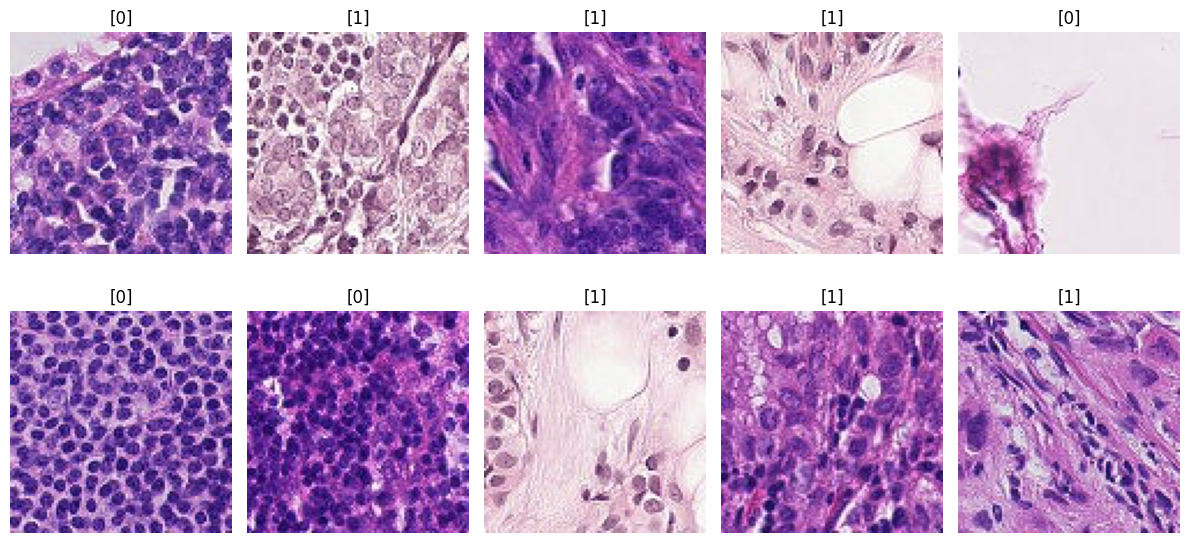

In [6]:

# Open the h5 files
with h5py.File(file_path_x, 'r') as data_file_x, h5py.File(file_path_y, 'r') as data_file_y:
    data_x = data_file_x['x'][:10]  # Load only the first 10 images
    data_y = data_file_y['y'][:10]  # Load corresponding labels

# Display the loaded images along with their labels
num_images_to_display = len(data_x)

plt.figure(figsize=(12, 6))
for i in range(num_images_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data_x[i])
    plt.axis('off')
    label_value = data_y[i][0][0]
    plt.title(f"{label_value}")

plt.tight_layout()
plt.show()

In [7]:
# Function to load data in batches
def load_data_in_batches(file_path_x, file_path_y, batch_size):
    with h5py.File(file_path_x, 'r') as data_file_x, h5py.File(file_path_y, 'r') as data_file_y:
        data_x = data_file_x['x']
        data_y = data_file_y['y'][:]
        total_samples = len(data_x)
        num_batches = total_samples // batch_size

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, total_samples)
            yield data_x[start_idx:end_idx], data_y[start_idx:end_idx].reshape(-1)  # Reshape labels


In [8]:
# Load train data in batches
train_batches = load_data_in_batches('/content/drive/My Drive/patch/camelyonpatch_level_2_split_train_x.h5', '/content/drive/My Drive/patch/camelyonpatch_level_2_split_train_y.h5', batch_size=65536)


In [9]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),  # Adjust dropout rate
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Use Nadam optimizer with a lower learning rate
optimizer = Nadam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
for batch_x, batch_y in train_batches:
    # Train the model using each batch
    for epoch in range(7):
        # Prepare validation data for each epoch
        with h5py.File('/content/drive/My Drive/patch/camelyonpatch_level_2_split_valid_x.h5', 'r') as valid_x_file:
            valid_x = valid_x_file['x'][:]
        with h5py.File('/content/drive/My Drive/patch/camelyonpatch_level_2_split_valid_y.h5', 'r') as valid_y_file:
            valid_y = valid_y_file['y'][:].reshape(-1)  # Reshape validation labels

        # Train the model with current batch and validation data
        model.fit(batch_x, batch_y, epochs=1, batch_size=32, validation_data=(valid_x, valid_y))

        # Clear memory after each epoch
        del valid_x, valid_y
        gc.collect()

    # Clear memory after each batch
    del batch_x, batch_y
    gc.collect()


2048/2048 [==============================] - 32s 16ms/step - loss: 0.1106 - accuracy: 0.9581 - val_loss: 0.6929 - val_accuracy: 0.8034


In [11]:
# Load test data
with h5py.File('/content/drive/My Drive/patch/camelyonpatch_level_2_split_test_x.h5', 'r') as test_x_file:
    test_x = test_x_file['x'][:]
with h5py.File('/content/drive/My Drive/patch/camelyonpatch_level_2_split_test_y.h5', 'r') as test_y_file:
    test_y = test_y_file['y'][:].reshape(-1)  # Reshape test labels


In [14]:
# Evaluate the model on the test set
model.evaluate(test_x, test_y)
print(f'Test accuracy: {test_acc}')

1024/1024 [==============================] - 4s 4ms/step - loss: 0.7917 - accuracy: 0.7775
Test accuracy: 0.77752685546875
